<a href="https://colab.research.google.com/github/jennsitta/jennsitta/blob/main/opticalspect_qn1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

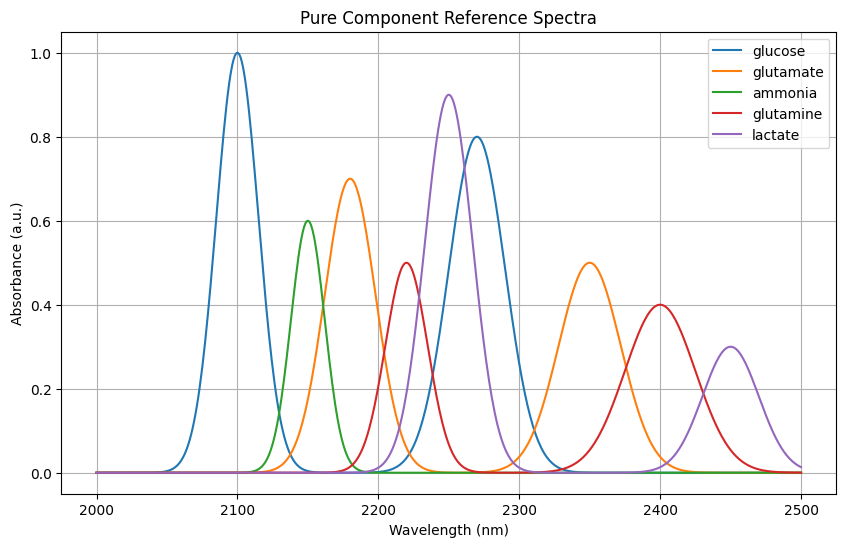

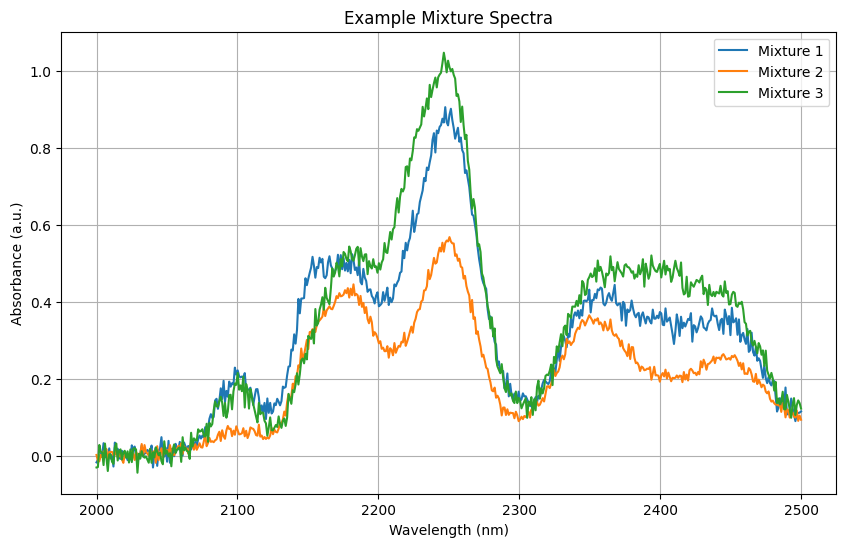

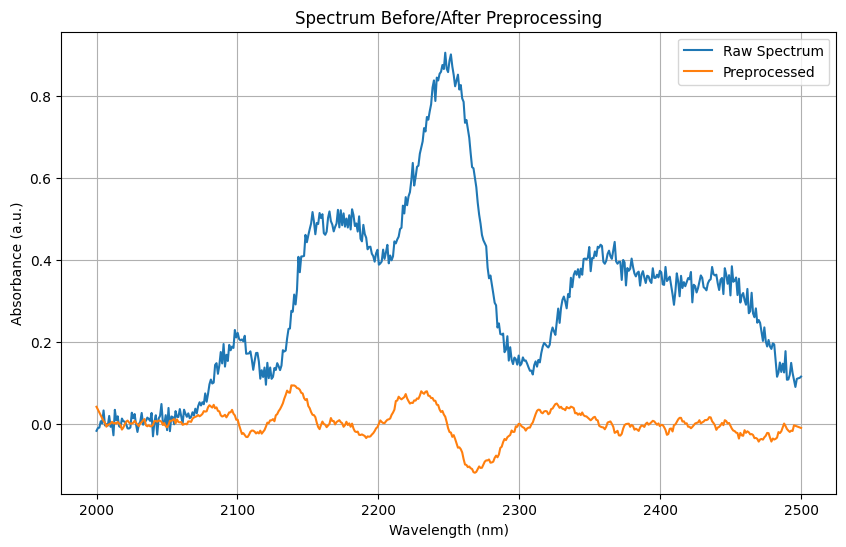

LW-PLSR Performance:
RMSE: 0.1167
R²: 0.8115

Cross-Validated Standard PLSR Performance:
RMSE: 0.1199
R²: 0.8221


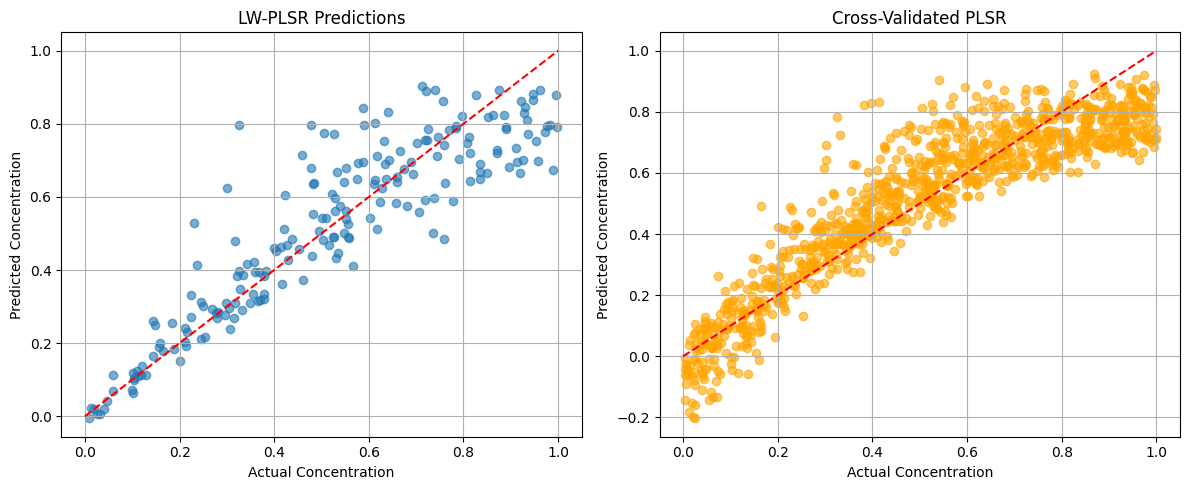


Clinical Performance Metrics:
Standard Error of Prediction (SEP): 23.34 mg/dL
Reference: Clinical targets typically require SEP < 40 mg/dL


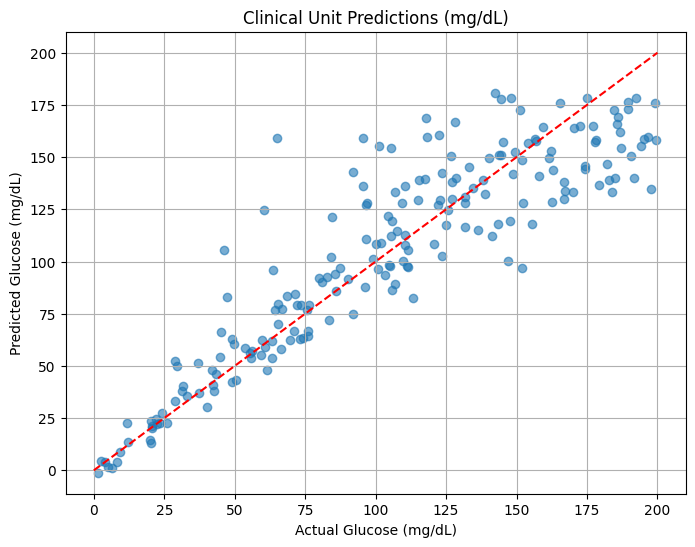

In [4]:
# %% [markdown]
"""
# Glucose Concentration Estimation from NIR Spectra
**Locally Weighted Partial Least Squares Regression (LW-PLSR) Implementation**
"""
# %%
# Install required packages
!pip install numpy matplotlib scikit-learn pandas scipy

# %%
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.signal import savgol_filter

# %% [markdown]
"""
## 1. Data Simulation - 5 Component NIR Spectra
Simulating glucose + interferents (glutamate, ammonia, glutamine, lactate)
"""
# %%
def simulate_nir_spectra(num_samples=500, noise_level=0.02):
    """Generate synthetic NIR spectra for 5-component mixture"""
    wavelengths = np.linspace(2000, 2500, 500)  # 2.0-2.5 µm range

    # Gaussian peak function
    def gaussian(x, center, height, width):
        return height * np.exp(-(x - center)**2 / (2*width**2))

    # Component spectra parameters [center (nm), height, width]
    components = {
        'glucose': [[2100, 1.0, 15], [2270, 0.8, 20]],
        'glutamate': [[2180, 0.7, 18], [2350, 0.5, 22]],
        'ammonia': [[2150, 0.6, 12]],
        'glutamine': [[2220, 0.5, 15], [2400, 0.4, 25]],
        'lactate': [[2250, 0.9, 17], [2450, 0.3, 20]]
    }

    # Generate pure component spectra
    pure_spectra = {}
    for comp, params in components.items():
        spectrum = np.zeros_like(wavelengths)
        for p in params:
            spectrum += gaussian(wavelengths, *p)
        pure_spectra[comp] = spectrum

    # Generate mixtures with random concentrations
    X = np.zeros((num_samples, len(wavelengths)))
    y = np.zeros(num_samples)  # Glucose concentrations

    for i in range(num_samples):
        conc = np.random.rand(5)  # Random concentrations 0-1
        y[i] = conc[0]  # First component is glucose

        # Create mixture spectrum
        mix = np.zeros_like(wavelengths)
        for j, (comp, spectrum) in enumerate(pure_spectra.items()):
            mix += conc[j] * spectrum

        # Add realistic noise and baseline
        mix += noise_level * np.random.randn(len(wavelengths)) * np.max(mix)
        mix += 0.1 * (wavelengths - 2000)/500  # Linear baseline

        X[i] = mix

    return wavelengths, X, y, pure_spectra

# Generate dataset
wavelengths, X, y, pure_spectra = simulate_nir_spectra(num_samples=1000)

# Plot pure components
plt.figure(figsize=(10, 6))
for comp, spectrum in pure_spectra.items():
    plt.plot(wavelengths, spectrum, label=comp)
plt.title('Pure Component Reference Spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (a.u.)')
plt.legend()
plt.grid(True)
plt.show()

# Plot example mixtures
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(wavelengths, X[i], label=f'Mixture {i+1}')
plt.title('Example Mixture Spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (a.u.)')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
"""
## 2. Preprocessing Pipeline
(Standard Normal Variate + Savitzky-Golay 1st Derivative)
"""
# %%
def preprocess_spectra(X, window=11, polyorder=2):
    """Apply SNV + Savitzky-Golay derivative preprocessing"""
    # Ensure window size is odd and greater than polyorder
    if window % 2 == 0:
        window += 1
    if window <= polyorder:
        window = polyorder + 2
        if window % 2 == 0: window += 1

    # Standard Normal Variate
    X_snv = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

    # Savitzky-Golay 1st derivative
    X_deriv = np.zeros_like(X_snv)
    for i in range(X_snv.shape[0]):
        X_deriv[i] = savgol_filter(X_snv[i], window, polyorder, deriv=1)

    return X_deriv

# Apply preprocessing
X_preprocessed = preprocess_spectra(X)

# Plot preprocessing results
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, X[0], label='Raw Spectrum')
plt.plot(wavelengths, X_preprocessed[0], label='Preprocessed')
plt.title('Spectrum Before/After Preprocessing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (a.u.)')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
"""
## 3. LW-PLSR Implementation
(Locally Weighted Partial Least Squares Regression)
"""
# %%
class LWPLSR:
    def __init__(self, n_components=5, tau=0.2):
        self.n_components = n_components
        self.tau = tau  # Bandwidth parameter
        self.X_train = None
        self.y_train = None

    def _local_weights(self, x_query, X):
        """Calculate Gaussian weights based on spectral similarity"""
        # Ensure inputs are numpy arrays for consistent operations
        x_query = np.asarray(x_query)
        X = np.asarray(X)
        distances = np.sum((X - x_query)**2, axis=1)
        # Add a small epsilon to the denominator of the exponent to prevent division by zero if tau is very small
        return np.exp(-distances / (2 * self.tau**2 + 1e-9))

    def fit(self, X, y):
        """Store training data"""
        # Ensure training data is numpy array
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)

    def predict(self, X_test):
        """Make predictions with local weighting"""
        # Ensure X_test is numpy array
        X_test = np.asarray(X_test)
        y_pred = np.zeros(X_test.shape[0])

        for i, x_test in enumerate(X_test):
            # Calculate sample weights for this test sample
            weights = self._local_weights(x_test, self.X_train)

            # Apply weights to training data by transforming X and y
            # Check if weights are all zero or very small to avoid errors
            if np.sum(weights) < 1e-10:
                 # If all weights are effectively zero, predict the mean of y_train
                 # In a real application, you might want a more sophisticated fallback or warning
                 y_pred[i] = np.mean(self.y_train)
                 continue

            # Calculate the square root of weights and apply it to the training data
            # This is the standard way to implement weighted least squares (and thus PLS)
            sqrt_weights = np.sqrt(weights)
            # Multiply each row of X_train by the corresponding sqrt_weight (broadcasting)
            X_train_weighted = self.X_train * sqrt_weights[:, np.newaxis]
            # Multiply y_train by the corresponding sqrt_weight
            y_train_weighted = self.y_train * sqrt_weights

            # Fit a new PLSR model using the weighted (transformed) training data
            # Initialize PLSR here for each prediction to ensure it uses only the weights relevant to x_test[i]
            local_pls = PLSRegression(n_components=self.n_components)
            # Fit using the transformed data (weights are now implicit in the data values)
            local_pls.fit(X_train_weighted, y_train_weighted)

            # Predict for the current test sample using the locally fitted model
            # The test sample itself is not weighted for prediction
            y_pred[i] = local_pls.predict(x_test.reshape(1, -1)).item()

        return y_pred

# %% [markdown]
"""
## 4. Model Training and Evaluation
"""
# %%
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42)

# Initialize and train LW-PLSR
lw_plsr = LWPLSR(n_components=5, tau=0.2)
lw_plsr.fit(X_train, y_train)

# Make predictions
y_pred = lw_plsr.predict(X_test)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("LW-PLSR Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Cross-validated performance (Standard PLSR for comparison)
# LW-PLSR cross-validation is more complex (e.g., leave-one-out cross-validation for each local model)
# This cross-validation is for standard PLSR as implemented previously
cv_pred = cross_val_predict(PLSRegression(n_components=5),
                           X_preprocessed, y, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y, cv_pred))
cv_r2 = r2_score(y, cv_pred)

print("\nCross-Validated Standard PLSR Performance:")
print(f"RMSE: {cv_rmse:.4f}")
print(f"R²: {cv_r2:.4f}")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Concentration')
plt.ylabel('Predicted Concentration')
plt.title('LW-PLSR Predictions')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y, cv_pred, alpha=0.6, color='orange')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Concentration')
plt.ylabel('Predicted Concentration')
plt.title('Cross-Validated PLSR')
plt.grid(True)

plt.tight_layout()
plt.show()

# %% [markdown]
"""
## 5. Interpretation and Clinical Relevance
"""
# %%
# Convert to clinical units (mg/dL)
# Assuming 0-1 concentration range maps to 0-200 mg/dL
y_test_mgdL = y_test * 200
y_pred_mgdL = y_pred * 200

sep = np.sqrt(np.mean((y_test_mgdL - y_pred_mgdL)**2))  # Standard Error of Prediction

print("\nClinical Performance Metrics:")
print(f"Standard Error of Prediction (SEP): {sep:.2f} mg/dL")
print("Reference: Clinical targets typically require SEP < 40 mg/dL")

# Plot in clinical units
plt.figure(figsize=(8, 6))
plt.scatter(y_test_mgdL, y_pred_mgdL, alpha=0.6)
plt.plot([0, 200], [0, 200], 'r--')
plt.xlabel('Actual Glucose (mg/dL)')
plt.ylabel('Predicted Glucose (mg/dL)')
plt.title('Clinical Unit Predictions (mg/dL)')
plt.grid(True)
plt.show()